## Installation of packages

We install essentia for audio analysis, musdb for the multi-track dataset Musdb-18 and museval to evaluate the source separation on this dataset.

In [1]:
!pip install essentia musdb museval

     |████████████████████████████████| 13.7 MB 13.9 MB/s 
     |████████████████████████████████| 963 kB 61.6 MB/s 
     |████████████████████████████████| 130 kB 53.4 MB/s 


In [2]:
!pip install --force essentia-tensorflow

     |████████████████████████████████| 291.4 MB 5.0 kB/s 
     |████████████████████████████████| 596 kB 13.0 MB/s 
     |████████████████████████████████| 15.7 MB 41.3 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requir

## Data preparation

In [3]:
import essentia
import essentia.standard as es
import matplotlib.pyplot as plt
import scipy

We download the short excerpts from musbd. 

In [4]:
import musdb
mus = musdb.DB(download=True)


Done!


A Track in `musdb` has the following attributes:

*  Track.name, the track name, consisting of Track.artist and Track.
title.
*   Track.path, the absolute path of the mixture which might be handy to process with external applications.
*   Track.audio, stereo mixture as an numpy array of shape (nb_samples, 2).
*   Track.rate, the sample rate of the mixture.
*   Track.sources, a dictionary of sources used for this track.
*   Track.stems, an numpy tensor of all five stereo sources of shape (5, nb_samples, 2). The stems are always in the following order: ['mixture', 'drums', 'bass', 'other', 'vocals'],
*   Track.targets, a dictionary of targets provided for this track. Note that for MUSDB, the sources and targets differ only in the existence of the accompaniment, which is the sum of all sources, except for the vocals. MUSDB supports the following targets: ['mixture', 'drums', 'bass', 'other', 'vocals', 'accompaniment', 'linear_mixture']. Note that some of the targets (such as accompaniment) are dynamically mixed on the fly.


The tracks are stereo with a sampling rate of 44100.

In [5]:
track = mus[7]
print(track.path)

/root/MUSDB18/MUSDB18-7/train/Aimee Norwich - Child.stem.mp4


In [6]:
import IPython.display as ipd
audio = track.audio
sr = track.rate
print(audio.shape)
print(sr)
ipd.Audio(audio.sum(axis=-1),rate=sr)

(300032, 2)
44100


## Harmonic-percussive separation with median filtering

We define a function to compute the short-term Fourier transform with Essentia. We add to the pool the magnitude, phase, the magnitude spectrogram in db for plotting and the median filtering of each time frame. 

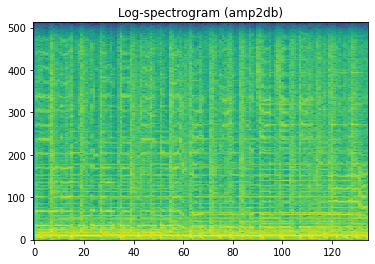

In [7]:
audio = es.MonoLoader(filename=track.path, sampleRate=10000)()

def STFT(audio):
  # Let's also get the other algorithms we will need, and a pool to store the results
  w = es.Windowing(type = 'hann')
  fft = es.FFT() # this gives us a complex FFT
  c2p = es.CartesianToPolar() # and this turns it into a pair (magnitude, phase)
  amp2db = es.UnaryOperator(type='lin2db', scale=2)
  mf = es.MedianFilter(kernelSize=17)
  pool = es.essentia.Pool()

  # Computing onset detection functions.
  for frame in es.FrameGenerator(audio, frameSize = 1024, hopSize = 512):
      mag, phase, = c2p(fft(w(frame)))
      pool.add('power magnitude', mag**2)
      pool.add('phase', phase)
      pool.add('spectrum_db', amp2db(mag))
      pool.add('mediany', mf(mag**2))
  
  return pool

pool = STFT(audio)
plt.imshow(pool['spectrum_db'].T, aspect = 'auto', origin='lower', interpolation='none')
plt.title("Log-spectrogram (amp2db)")
plt.show()

Percussive events are vertical lines while harmonic events are horizontal lines. We smooth out percussive events by replacing large spikes with the median on the x axis, for every frequency bin. Conversely, we replace large spikes on the y axis with the median to smooth out harmonic peaks at each time frame. 

*Fitzgerald, Derry. "Harmonic/percussive separation using median filtering." Proceedings of the International Conference on Digital Audio Effects (DAFx). Vol. 13. 2010. [PDF](http://dafx10.iem.at/papers/DerryFitzGerald_DAFx10_P15.pdf)*

Note that we use the `scipy` function `medfilt` for median filtering. On the y axis this could have been done in essentia with `MedianFilter`. 

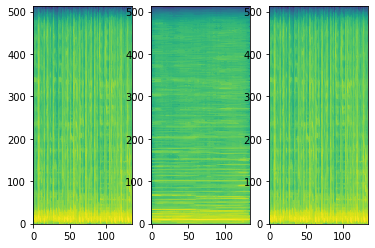

In [8]:
import scipy
import scipy.signal
import numpy as np

filter_len = 17
filter_x = scipy.signal.medfilt(pool['power magnitude'], [1, filter_len])
filter_y = scipy.signal.medfilt(pool['power magnitude'], [filter_len, 1])
fig, axs = plt.subplots(1,3)
axs[0].imshow(np.log2(filter_x).T, aspect = 'auto', origin='lower', interpolation='none')
axs[1].imshow(np.log2(filter_y).T, aspect = 'auto', origin='lower', interpolation='none')
axs[2].imshow(np.log2(pool['mediany']).T, aspect = 'auto', origin='lower', interpolation='none')
fig.show()

We use the median filtering estimations to compute two binary mask for percussive and harmonic sources. We multiply the original magnitude spectrogram with the masks to obtain the spectrogram of the sources

In [9]:
mask_x = filter_x > filter_y
mask_y = filter_x <= filter_y

pmag_perc = mask_x * pool['power magnitude'] 
pmag_harm = mask_y * pool['power magnitude']

We write a function to invert the short-term Fourier transform for the magnitude spectrogram of percussive and harmonic sources, using the phase of the original mixture signal.

In [10]:
def ISTFT(magnitude,phase,filename='outputFilename.wav',sr=10000):
  ifft = es.IFFT()
  p2c = es.PolarToCartesian()
  overl = es.OverlapAdd(frameSize = 1024, hopSize = 512)
  awrite = es.MonoWriter(filename = filename, sampleRate = sr)

  audioout = np.array(0) # initialize output array

  for mag,ph in zip(magnitude,phase):
      frame = p2c(mag,ph)
      # STFT synthesis
      out = overl(ifft(frame))
      audioout = np.append(audioout, out)

  return audioout

In [11]:
audio_h1 = ISTFT(np.sqrt(pmag_harm),pool['phase'],sr=10000)
ipd.Audio(audio_h1,rate=10000)

In [12]:
audio_p1 = ISTFT(np.sqrt(pmag_perc),pool['phase'],sr=10000)
ipd.Audio(audio_p1,rate=10000)

In many cases a better option to binary mask is to compute soft masks, by dividing the estimation with the sum of all the estimatons. 
Again, the masks are multiplied with the spectrogram of the mixture to obtain the spectrograms associated with the sources.

In [13]:
mask_x = filter_x / (filter_x + filter_y)
mask_y = filter_y / (filter_x + filter_y)

pmag_perc = mask_x * pool['power magnitude'] 
pmag_harm = mask_y * pool['power magnitude']

We perform the inverse STFT to obtain the audio signals of the sources.

In [14]:
audio_h2 = ISTFT(np.sqrt(pmag_harm),pool['phase'],sr=10000)
ipd.Audio(audio_h1,rate=10000)

In [15]:
audio_p2 = ISTFT(np.sqrt(pmag_perc),pool['phase'],sr=10000)
ipd.Audio(audio_p1,rate=10000)

We compare the estimations with the targets which we extract from the musdb dataset. Here we use the drums track as the percussive track and the rest as harmonic. 

In [16]:
target_nondrums = (track.targets['linear_mixture'].audio - track.targets['drums'].audio).sum(axis=-1)
target_nondrums = es.Resample(inputSampleRate=track.rate,outputSampleRate=10000)(target_nondrums)
ipd.Audio(target_nondrums,rate=10000)

In [17]:
target_drums = track.targets['drums'].audio.sum(axis=-1)
target_drums = es.Resample(inputSampleRate=track.rate,outputSampleRate=10000)(target_drums)
ipd.Audio(target_drums,rate=10000)

`museval` relies on the `BSS_EVAL` images evaluation to perform an objective evaluation of source separation estimations. 
```
museval.evaluate(references, estimates, win=44100, hop=44100, mode='v4', padding=True)
```
Parameters
```
references np.ndarray, shape=(nsrc, nsampl, nchan)
array containing true reference sources
estimates np.ndarray, shape=(nsrc, nsampl, nchan)
array containing estimated sources
window int, defaults to 44100
window size in samples
hopint
hop size in samples, defaults to 44100 (no overlap)
modestr
BSSEval version, default to v4
```
Returns
```
SDR np.ndarray, shape=(nsrc,)
vector of Signal to Distortion Ratios (SDR)
ISR np.ndarray, shape=(nsrc,)
vector of Source to Spatial Distortion Image (ISR)
SIR np.ndarray, shape=(nsrc,)
vector of Source to Interference Ratios (SIR)
SAR np.ndarray, shape=(nsrc,)
vector of Sources to Artifacts Ratios (SAR)

```





The output of `museval.evaluate` is a series of metrics for each window/hop. These metrics are SDR, ISR, SIR, SAR. 





In [18]:
import museval 
mode='v4'
win=1.0
hop=1.0
sr=10000
          
SDR, ISR, SIR, SAR = museval.evaluate(
    np.expand_dims(np.vstack([target_drums,target_nondrums]),-1),
    np.expand_dims(np.vstack([audio_p2,audio_h2]),-1),
    win=int(win*sr),
    hop=int(hop*sr),
    mode=mode
)
print("Soft mask meanSDR={} meanSIR={} meanSAR={}".format(SDR.mean(axis=-1),SIR.mean(axis=-1),SAR.mean(axis=-1)))

SDR, ISR, SIR, SAR = museval.evaluate(
    np.expand_dims(np.vstack([target_drums,target_nondrums]),-1),
    np.expand_dims(np.vstack([audio_p1,audio_h1]),-1),
    win=int(win*sr),
    hop=int(hop*sr),
    mode=mode
)
print("Binary mask meanSDR={} meanSIR={} meanSAR={}".format(SDR.mean(axis=-1),SIR.mean(axis=-1),SAR.mean(axis=-1)))


Soft mask meanSDR=[-1.10174709  0.15326522] meanSIR=[-10.98242844  18.7253155 ] meanSAR=[-4.9548224   1.40417478]
Binary mask meanSDR=[-0.74615451  0.13474365] meanSIR=[ 1.64136869 21.40715768] meanSAR=[-11.45060495   1.58033659]


## Background vs foreground separation using REPET

The REPET algorithm is a lightweight algorithm for source separation, relying on the repeating/non-repeating patterns in music. 

*Rafii, Zafar, and Bryan Pardo. "Repeating pattern extraction technique (REPET): A simple method for music/voice separation." IEEE transactions on audio, speech, and language processing 21.1 (2012): 73-84.*

In [19]:
!git clone https://github.com/zafarrafii/REPET-Python
%cd REPET-Python/

Cloning into 'REPET-Python'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 301 (delta 34), reused 37 (delta 15), pack-reused 242
Receiving objects: 100% (301/301), 15.65 MiB | 26.58 MiB/s, done.
Resolving deltas: 100% (155/155), done.
/content/REPET-Python


We use the adaptive REPET to separate the background signal. Then the foreground is subtracted from the original using the background signal. 

In [20]:
import repet

audio.shape 
# Estimate the background signal, and the foreground signal
background_signal = repet.original(track.audio, track.rate)
foreground_signal = track.audio-background_signal

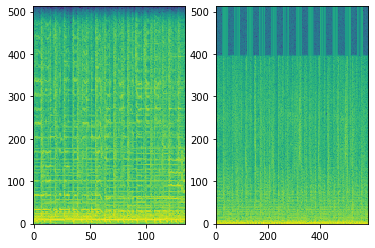

In [21]:
pool_background = STFT(background_signal.sum(-1))
pool_foreground = STFT(foreground_signal.sum(-1))

fig, axs = plt.subplots(1,2)
axs[0].imshow(pool['spectrum_db'].T, aspect = 'auto', origin='lower', interpolation='none')
axs[1].imshow(pool_background['spectrum_db'].T, aspect = 'auto', origin='lower', interpolation='none')
fig.show()

In [22]:
ipd.Audio(background_signal.sum(axis=-1),rate=track.rate)

In [23]:
ipd.Audio(foreground_signal.sum(axis=-1),rate=track.rate)

In [24]:
target_nonvoice = track.targets['accompaniment'].audio
ipd.Audio(target_nonvoice.sum(axis=-1),rate=track.rate)

In [25]:
target_voice = track.targets['vocals'].audio
ipd.Audio(target_voice.sum(axis=-1),rate=track.rate)

In [26]:
import museval 
mode='v4'
win=1.0
hop=1.0
sr=track.rate

SDR, ISR, SIR, SAR = museval.evaluate(
    np.stack([target_nonvoice,target_voice]),
    np.stack([background_signal,foreground_signal]),
    win=int(win*sr),
    hop=int(hop*sr),
    mode=mode
)
print("mean SDR={} mean SIR={} mean SAR={}".format(SDR.mean(axis=-1),SIR.mean(axis=-1),SAR.mean(axis=-1)))

mean SDR=[12.0317121   1.57424263] mean SIR=[16.44244492  1.20143327] mean SAR=[14.2508814   2.33171302]


## Spleeter source separation with UNet

We download the spleeter model from the Essentia page. 

In [27]:
!wget https://essentia.upf.edu/models/source-separation/spleeter/spleeter-2s-3.pb
!wget https://essentia.upf.edu/models/source-separation/spleeter/spleeter-2s-3.json 

--2022-02-23 16:05:37--  https://essentia.upf.edu/models/source-separation/spleeter/spleeter-2s-3.pb
Resolving essentia.upf.edu (essentia.upf.edu)... 84.89.139.43
Connecting to essentia.upf.edu (essentia.upf.edu)|84.89.139.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78814287 (75M)
Saving to: ‘spleeter-2s-3.pb’

spleeter-2s-3.pb    100%[===================>]  75.16M  3.37MB/s    in 26s     

2022-02-23 16:06:04 (2.84 MB/s) - ‘spleeter-2s-3.pb’ saved [78814287/78814287]

--2022-02-23 16:06:04--  https://essentia.upf.edu/models/source-separation/spleeter/spleeter-2s-3.json
Resolving essentia.upf.edu (essentia.upf.edu)... 84.89.139.43
Connecting to essentia.upf.edu (essentia.upf.edu)|84.89.139.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1352 (1.3K) [application/json]
Saving to: ‘spleeter-2s-3.json’

spleeter-2s-3.json  100%[===================>]   1.32K  --.-KB/s    in 0s      

2022-02-23 16:06:04 (103 MB/s) - ‘spleeter-2s-

The model separates vocals and accompaniment and in the Spleeter implementation takes as input the waveform of the mixture. It computes the magnitude spectrogram inside the Tensorflow processing graph. 

We initialize the input nodes `i_node` and the output nodes `o_node` for the neural network. We prepare the pool which is given as input to the model. 

The model predicts waveforms for vocals and accompaniment. 

In [28]:
from essentia.standard import TensorflowPredict
nsources = 2
i_node = ['waveform']
sources = ['vocals', 'accompaniment']
o_node = ['waveform_'+source for source in sources]

pool = essentia.Pool()
sr = track.rate
audio = essentia.array(track.audio).reshape([-1, 2, 1, 1])
print('input tensor shape:', audio.shape)
model = TensorflowPredict(graphFilename='spleeter-2s-3.pb', inputs=i_node, outputs=o_node, squeeze=True)
pool.set(i_node[0], audio)
preds = []
for i,node in enumerate(o_node):
    preds.append(model(pool)[node].squeeze())
    print('output tensor shape:', preds[-1].shape)

input tensor shape: (300032, 2, 1, 1)
output tensor shape: (300032, 2)
output tensor shape: (300032, 2)


In [29]:
ipd.Audio(preds[0].sum(axis=-1),rate=track.rate)

In [30]:
ipd.Audio(preds[1].sum(axis=-1),rate=track.rate)

The evaluation shows considerable improvement when comparing with REPET and median filtering. However, it is not clear whether this track was used for training this model, along with other songs from Deezer. 

In [31]:
import museval 
mode='v4'
win=1.0
hop=1.0
sr=track.rate


SDR, ISR, SIR, SAR = museval.evaluate(
    np.stack([target_nonvoice,target_voice]),
    np.stack([preds[1],preds[0]]),
    win=int(win*sr),
    hop=int(hop*sr),
    mode=mode
)
print("mean SDR={} mean SIR={} mean SAR={}".format(SDR.mean(axis=-1),SIR.mean(axis=-1),SAR.mean(axis=-1)))

mean SDR=[19.07769987  9.2771492 ] mean SIR=[25.35188042 16.17569547] mean SAR=[18.72081623  9.25505645]


## Waveform source separation with DEMUCS

Let's try to perform source separation using one of the state of the art models, DEMUCS. 

In [32]:
!pip install demucs

     |████████████████████████████████| 1.5 MB 12.7 MB/s 
     |████████████████████████████████| 74 kB 2.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 391 kB 50.6 MB/s 
     |████████████████████████████████| 58 kB 5.1 MB/s 
     |████████████████████████████████| 190 kB 53.3 MB/s 
     |████████████████████████████████| 46 kB 2.9 MB/s 
     |████████████████████████████████| 74 kB 2.6 MB/s 
     |████████████████████████████████| 70 kB 7.3 MB/s 
     |████████████████████████████████| 112 kB 61.3 MB/s 
  Created wheel for demucs: filename=demucs-3.0.3-py3-none-any.whl size=56836 sha256=7a7f8c5c5425ba2f55efea8aac70354000943010f039a8128f730a5cff8197e5
  Stored in directory: /root/.cache/pip/wheels/ce/34/4a/7fa7b06e9f4013a24a31d73d3ee972c3c14356e1e777ddf08a
  Created wheel for julius: filename=julius-0.2.6-py3-none-any.whl size=20965 sha256=479973ef62c704d6e5cc

In [33]:
import os
model="mdx_extra"
input_file = track.path
out_path = os.path.abspath(os.getcwd())
!python3 -m demucs.separate -o "$out_path" -n "$model" "$input_file"


Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/e51eebcc-c1b80bdd.th" to /root/.cache/torch/hub/checkpoints/e51eebcc-c1b80bdd.th
100% 160M/160M [00:07<00:00, 22.1MB/s]
Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/a1d90b5c-ae9d2452.th" to /root/.cache/torch/hub/checkpoints/a1d90b5c-ae9d2452.th
100% 160M/160M [00:08<00:00, 18.8MB/s]
Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/5d2d6c55-db83574e.th" to /root/.cache/torch/hub/checkpoints/5d2d6c55-db83574e.th
100% 160M/160M [00:08<00:00, 18.8MB/s]
Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/cfa93e08-61801ae1.th" to /root/.cache/torch/hub/checkpoints/cfa93e08-61801ae1.th
100% 160M/160M [00:09<00:00, 16.8MB/s]
Selected model is a bag of 4 models. You will see that many progress bars per track.
Separated tracks will be stored in /content/REPET-Python/mdx_extra
Separating track /root/MUSDB18/MUSDB18-7/train/Aimee Norwich - Child.stem.mp4
100%|█████████████████████████████████████

In [34]:
!ls "$out_path"/mdx_extra
!pip install stempeg

'Aimee Norwich - Child.stem'


In [35]:
import stempeg
dirlist = [x[0] for x in os.walk(os.path.join(out_path,"mdx_extra")) if x[0].endswith('.stem')]
S, rate = stempeg.read_stems(os.path.join(out_path,"mdx_extra",dirlist[0],'vocals.wav'))
ipd.Audio(target_voice.sum(axis=-1),rate=track.rate)